In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
print("Libraries imported successfully.....")

Libraries imported successfully.....


In [2]:
#Importing data
df = pd.read_csv("telecom_customer_churn.csv")

print("Data imported successfully.....")

Data imported successfully.....


In [3]:
#Separate numerical and categorical columns

from preprolib import myfunctions
num_cols = []
cat_cols = []

ignore_list = ['Zip Code', 'Longitude', 'Latitude', 
                'Customer ID', 'Churn Category', 
                'Churn Reason', 'Customer Status', 'City']

myfunctions.cat_or_num(df, ignore_list, num_cols, cat_cols)

label = 'Customer Status'


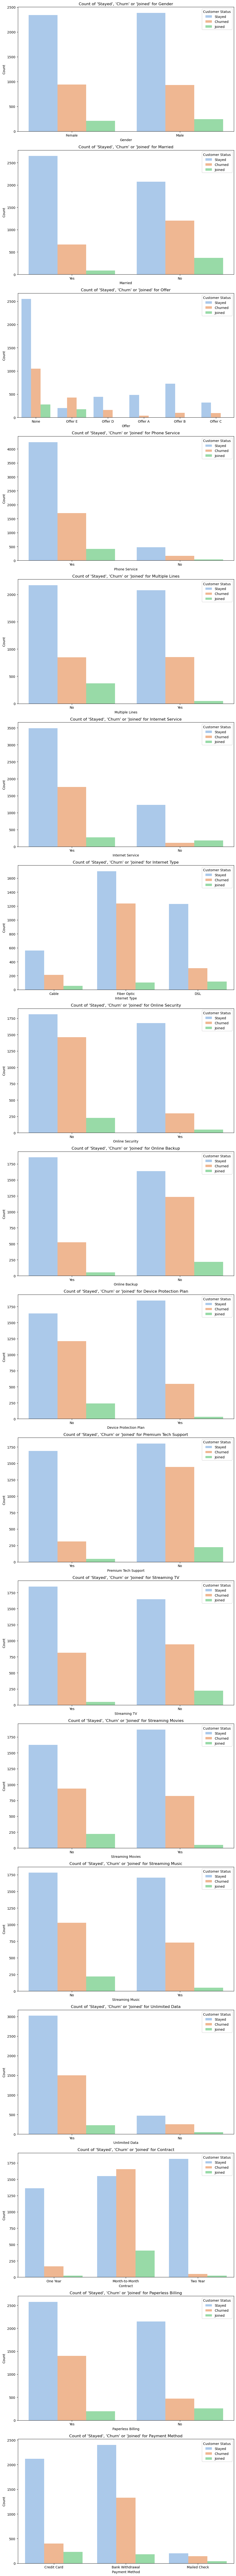

In [4]:
plt.figure(figsize=(10, 6 * len(cat_cols)))

for idx, cat_col in enumerate(cat_cols, start=1):
    plt.subplot(len(cat_cols), 1, idx)
    sns.countplot(data=df, x=cat_col, hue='Customer Status', palette='pastel')
    plt.title(f"Count of 'Stayed', 'Churn' or 'Joined' for {cat_col}")
    plt.xlabel(cat_col)
    plt.ylabel('Count')

plt.tight_layout()
from scipy.stats import chi2_contingency
plt.show()

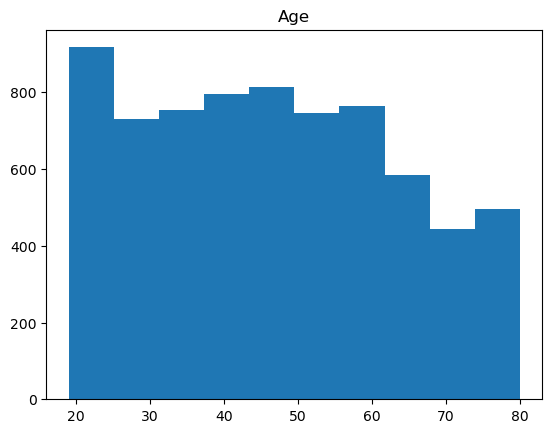

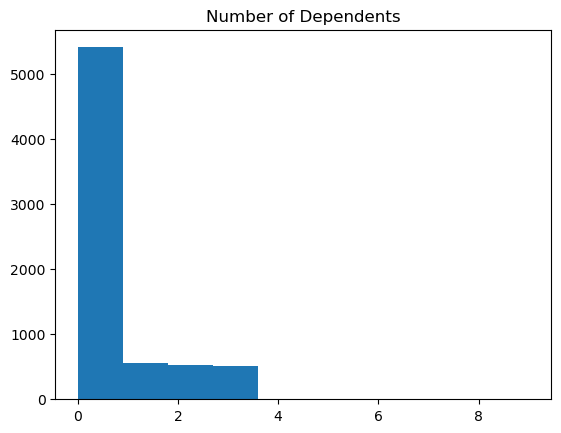

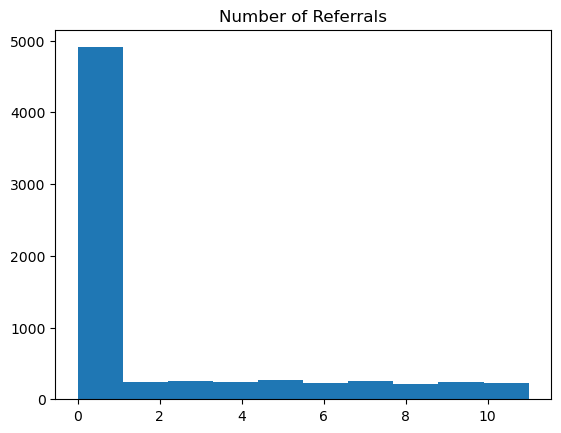

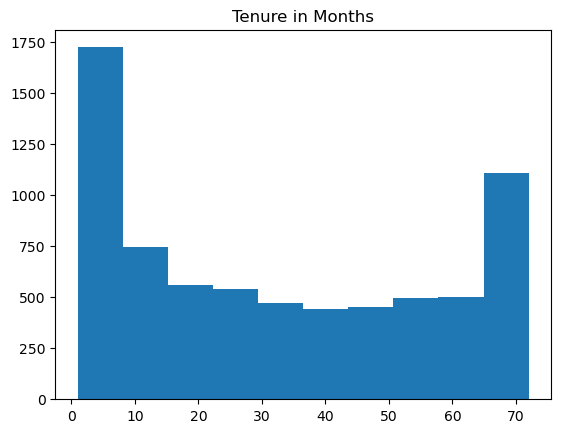

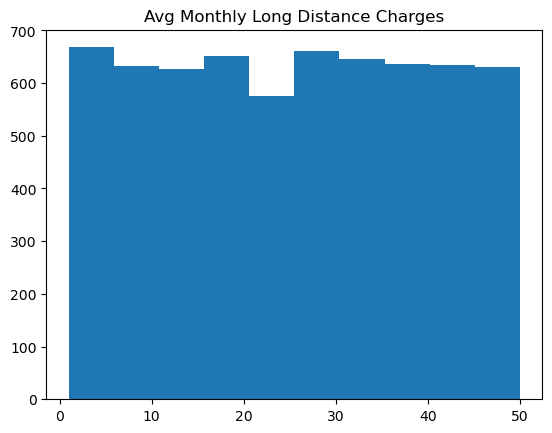

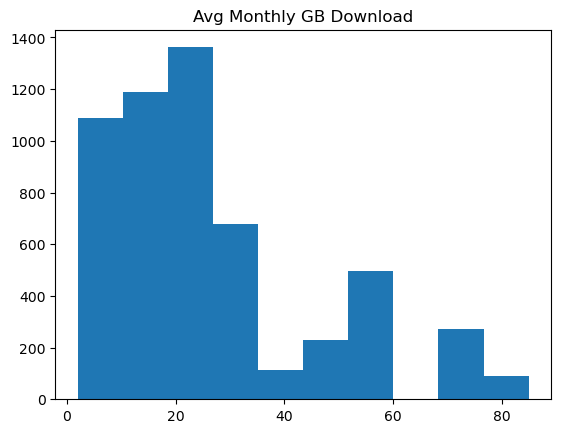

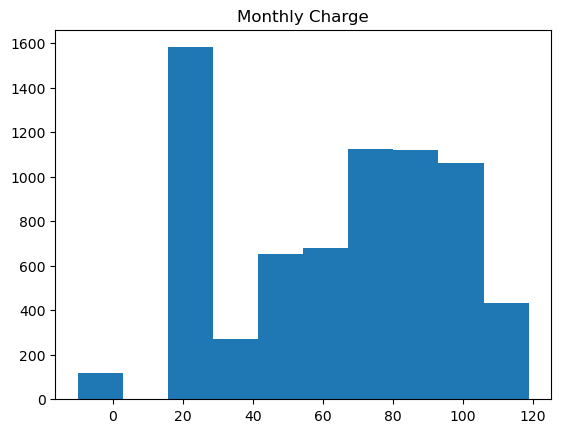

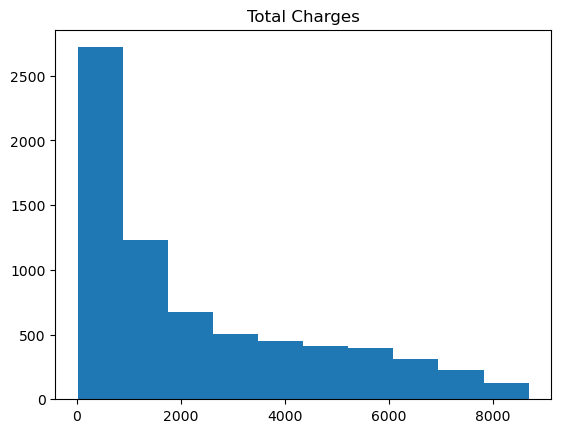

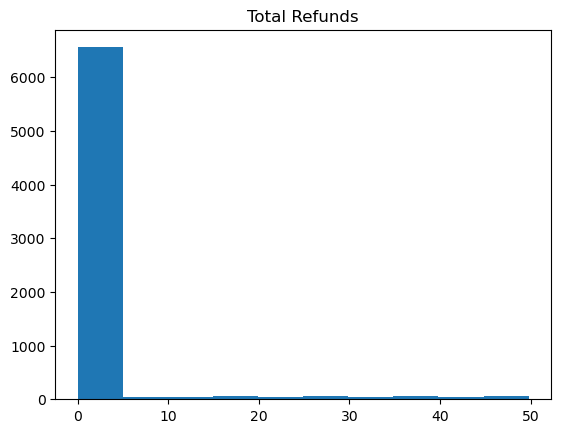

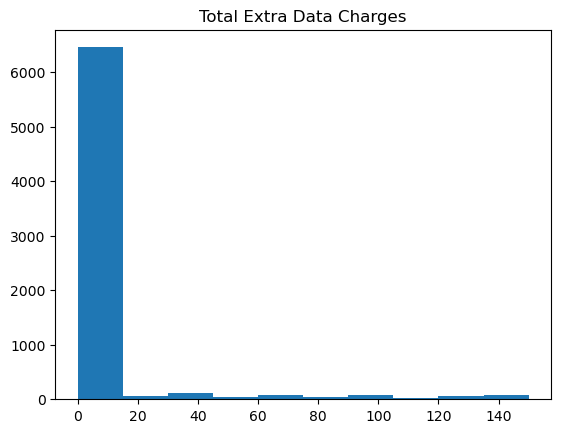

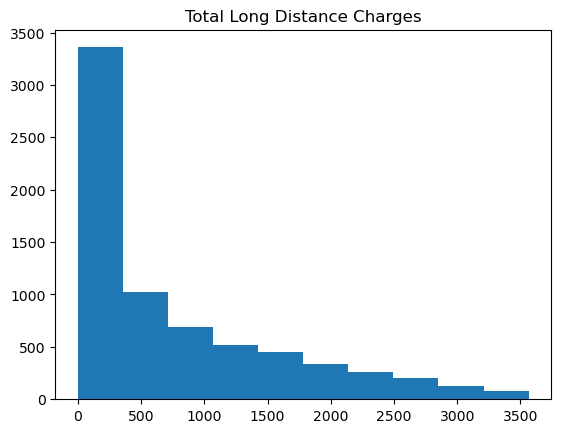

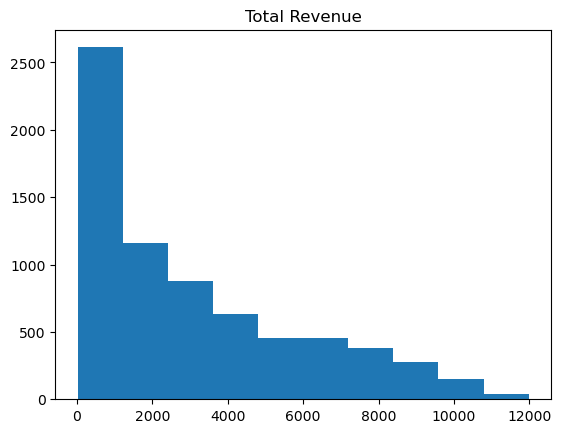

In [5]:
#distributions for all numeric variables 
for i in df[num_cols]:
    plt.hist(df[num_cols][i])
    plt.title(i)
    plt.show()

                                        Age  Number of Dependents  \
Age                                1.000000             -0.119000   
Number of Dependents              -0.119000              1.000000   
Number of Referrals               -0.025141              0.278003   
Tenure in Months                   0.009927              0.108237   
Avg Monthly Long Distance Charges -0.020010             -0.002898   
Avg Monthly GB Download           -0.566518              0.300802   
Monthly Charge                     0.134511             -0.125649   
Total Charges                      0.059684              0.022535   
Total Refunds                      0.024168              0.014023   
Total Extra Data Charges           0.025036             -0.014436   
Total Long Distance Charges        0.003065              0.068966   
Total Revenue                      0.048265              0.038038   

                                   Number of Referrals  Tenure in Months  \
Age                       

<AxesSubplot: >

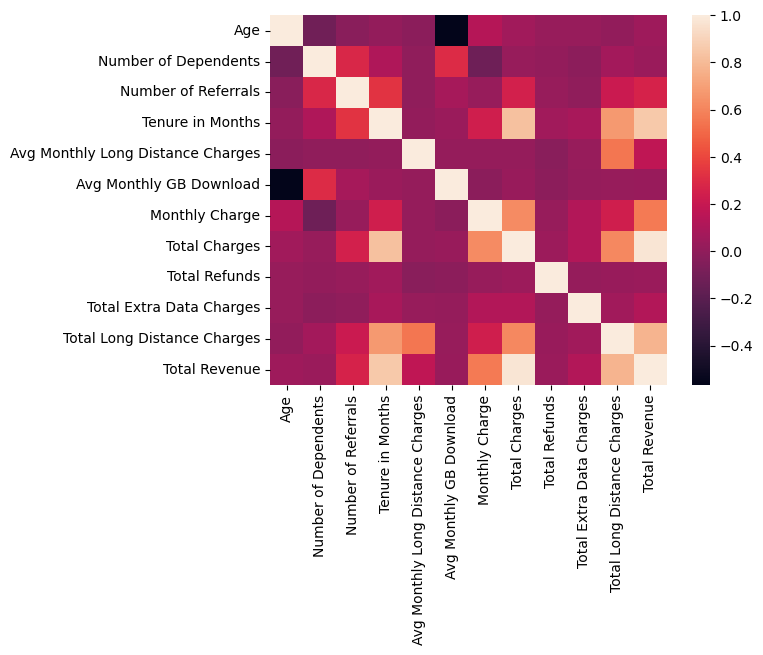

In [6]:
print(df[num_cols].corr())
sns.heatmap(df[num_cols].corr())

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Define the features and label
features = cat_cols + num_cols
label = 'Customer Status'

# Convert the label column to ordinal categories
label_encoder = OrdinalEncoder()
y = label_encoder.fit_transform(df[label].values.reshape(-1, 1))

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], y, test_size=0.3, random_state=0)

# Define a pipeline for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define a pipeline for categorical columns
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a ColumnTransformer to apply the pipeline to the numeric and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Fit the preprocessor to the training data and transform both the training and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print('Training Set: %d, Test Set: %d \n' % (len(X_train), len(X_test)))

# Print the transformed DataFrames
print("X_train_Transformed:\n", X_train_transformed)
print("\nX_test_Transformed:\n", X_test_transformed)


Training Set: 4930, Test Set: 2113 

X_train_Transformed:
 [[ 0.19231534  2.67193796  1.36376374 ...  1.          0.
   0.        ]
 [ 0.84799626  2.67193796 -0.64021696 ...  0.          1.
   0.        ]
 [ 0.96721097 -0.48470094  1.36376374 ...  0.          1.
   0.        ]
 ...
 [ 0.07310062 -0.48470094 -0.64021696 ...  1.          0.
   0.        ]
 [ 0.07310062 -0.48470094 -0.64021696 ...  1.          0.
   0.        ]
 [ 0.31153005  0.56751203 -0.30622017 ...  1.          0.
   0.        ]]

X_test_Transformed:
 [[ 0.60956683  0.56751203  0.36177339 ...  1.          0.
   0.        ]
 [ 0.72878155 -0.48470094 -0.64021696 ...  1.          0.
   0.        ]
 [-0.64218766 -0.48470094 -0.64021696 ...  0.          1.
   0.        ]
 ...
 [ 0.19231534 -0.48470094  0.02777661 ...  0.          1.
   0.        ]
 [ 0.84799626  1.61972499 -0.64021696 ...  1.          0.
   0.        ]
 [-1.53629801 -0.48470094  1.36376374 ...  1.          0.
   0.        ]]


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier#
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score


from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

#mcm = confusion_matrix(y_test, predictions)

lr_model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000).fit(X_train_transformed, y_train)
kn_model = KNeighborsClassifier().fit(X_train_transformed, y_train)
dt_model = DecisionTreeClassifier().fit(X_train_transformed, y_train)
rf_model = RandomForestClassifier().fit(X_train_transformed, y_train)
nb_model = GaussianNB().fit(X_train_transformed, y_train)
ab_model = AdaBoostClassifier().fit(X_train_transformed, y_train)
#svc_model = SVC().fit(X_train_transformed,y_train)


models = [
    ('Logistic Regression', lr_model),
    ('K-Nearest Neighbors', kn_model),
    ('Decision Tree', dt_model),
    ('Random Forest', rf_model),
    ('Gaussian Naive Bayes', nb_model),
    ('AdaBoost', ab_model)
]


c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\User\AppData\Local\Temp\ipykernel_11388\2557903111.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = RandomForestClassifier().fit(X_train_transformed, y_train)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expe

In [16]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Define lists to store model evaluation results

model_names = []
recall_scores = []
f1_scores = []
precision_scores = []
accuracy_scores = []

def evaluate_model(curr_model, model_name, X_test, y_test):
    predictions = curr_model.predict(X_test)

    # Calculate the necessary metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    # Append model name and metric scores to the respective lists
    model_names.append(model_name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)





In [17]:
# Example usage
for model_name, model in models:
    evaluate_model(model, model_name, X_test_transformed, y_test)

# Create a DataFrame to store the model evaluation results
model_evaluation_df = pd.DataFrame({
    'Model': model_names,
    'Recall': recall_scores,
    'F1-score': f1_scores,
    'Precision': precision_scores,
    'Accuracy': accuracy_scores
})
model_evaluation_df.sort_index()

c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\User\.conda\envs\NewEnv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Recall,F1-score,Precision,Accuracy
0,Logistic Regression,0.825367,0.825931,0.827337,0.825367
1,K-Nearest Neighbors,0.750592,0.749405,0.754928,0.750592
2,Decision Tree,0.783247,0.786134,0.790546,0.783247
3,Random Forest,0.836252,0.831145,0.830297,0.836252
4,Gaussian Naive Bayes,0.730241,0.745078,0.790164,0.730241
5,AdaBoost,0.751065,0.693595,0.668214,0.751065


In [18]:
# Print the DataFrame with model evaluation results
# Sort the DataFrame by accuracy in descending order
model_evaluation_df.sort_values(by='Accuracy', ascending=False, inplace=True)
model_evaluation_df.reset_index(drop=True, inplace=True)

print("\nModel Evaluation:")
print(model_evaluation_df)



Model Evaluation:
                  Model    Recall  F1-score  Precision  Accuracy
0         Random Forest  0.836252  0.831145   0.830297  0.836252
1   Logistic Regression  0.825367  0.825931   0.827337  0.825367
2         Decision Tree  0.783247  0.786134   0.790546  0.783247
3              AdaBoost  0.751065  0.693595   0.668214  0.751065
4   K-Nearest Neighbors  0.750592  0.749405   0.754928  0.750592
5  Gaussian Naive Bayes  0.730241  0.745078   0.790164  0.730241
